# PyTorch - Decoder Transformer Generative Model from scratch
* Notebook by Adam Lang
* Date: 11/12/24

# Overview
* In this notebook I will demonstrate how to build a decoder style generative transformer from scratch similar to GPT from scratch using PyTorch.

# Imports

In [66]:
# install pytorch lightning
!pip install lightning lightning_fabric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 7.7 MB/s eta 0:00:00


In [67]:
## imports
import torch
import torch.nn as nn
import torch.nn.functional as F #access softmax() to calculate attention

from torch.optim import Adam #optimizer to fit nn to data with backpropagation
from torch.utils.data import TensorDataset, DataLoader #transformer network, dataset

import lightning as L #pytorch lightning
from lightning_fabric.utilities.seed import seed_everything


# Create Inputs and Labels
* Examples of what we can generate:
1. What is Generative AI --> Awesome!
2. Generative AI is what? --> Awesome!

## Creating `token_to_id` mapping
* We do this so we can map tokens to id numbers because PyTorch word embedding function that we are going to use `nn.Embedding()` will only accept numbers as input.
* Token to id mapping makes it easier for transformer to interpret input and output to model.

In [4]:
## create a vocabulary dictionary --> `token_to_id`
token_to_id = {
    'what' : 0,
    'is' : 1,
    'generative AI' : 2,
    'awesome' : 3,
    '<EOS>' : 4,
}

## map tokens to ids <---> ids to tokens
id_to_token = dict(map(reversed, token_to_id.items()))

Below we code the raw input tensors to simulate 2 input prompts we are using:
1. "What is generative AI?" --> output is "Awesome"
2. "Generative AI is what" --> output "Awesome"

In [7]:
## raw code for input tensor to model
inputs = torch.tensor([[token_to_id["what"], # inputs 1st prompt
                       token_to_id["is"],
                       token_to_id["generative AI"],
                       token_to_id["<EOS>"],
                       token_to_id["awesome"]],

                       # inputs for 2nd prompt
                       [token_to_id["generative AI"],
                        token_to_id["is"],
                        token_to_id["what"],
                        token_to_id["<EOS>"],
                        token_to_id["awesome"]]])


In [9]:
## raw code labels for first prompt
labels = torch.tensor([[token_to_id["is"], #labels 1st prompt
                        token_to_id["generative AI"],
                        token_to_id["<EOS>"],
                        token_to_id["awesome"],
                        token_to_id["<EOS>"]],

                       # labels for 2nd prompt
                       [token_to_id["is"],
                        token_to_id["what"],
                        token_to_id["<EOS>"],
                        token_to_id["awesome"],
                        token_to_id["<EOS>"]]


                       ])

# Dataset & DataLoader
* Now we pass **inputs** and **labels** to **TensorDataset()** and create a PyTorch Dataset.
* We then pass the **dataset** --> **DataLoader**

In [10]:
## create torch dataset
dataset = TensorDataset(inputs, labels)

## pass to DataLoader
dataloader = DataLoader(dataset)

# Create Embeddings + Positional Encoding
* We can use PyTorch built in function `nn.Embedding()` for this.

## Positional Encodings
* Keeps track of word order during input and output to transformer.
* Positional Encodings usually utilize alternating sine and cosine to calculate values for each token and embedding value.
* Equation for position encoding & embedding:

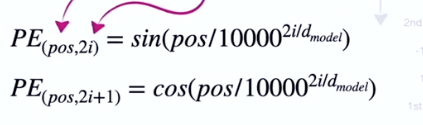

Note:
* Formula for the Sin function is identical to the formula for the Cosine function. The only difference is the "+1" for Cosine just noting it is Cosine.
* `d-model` is the number of tokens we are using in production.

In [ ]:
## precompute and add Position encoding values
class PositionEncoding(nn.Module):

  def __init__(self,
               d_model=2, # model dimension -- num word emb vals per token
               max_len=3): # max num tokens transformer can process

    super().__init__()

    # create matrix of positional encoding values -- init with 0's
    ## max_len -> rows, d_model -> columns
    pe = torch.zeros(max_len, d_model)

    # create column matrix position --> represents positions (pos) for each token
    ## torch.arange --> 0 to max_len, unsqueeze(1) --> turn nums to column matrix
    position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)

    # create divisor term --> sequence of numbers
    div_term = 1/torch.tensor(10000.0)**(torch.arange(start=0, end=d_model, step=2).float() / d_model) ## divide by num of word embeddings per token

    pe[:, 0::2] == torch.sin(position * div_term) ## first column --> sin function
    pe[:, 1::2] == torch.cos(position * div_term) ## second column --> cos function

    self.register_buffer('pe', pe) ## move to GPU if available


  ## forward pass
  def forward(self, word_embeddings):
    """Takes in word embeddings & adds positional encodings to them"""
    return word_embeddings + self.pe[:word_embeddings.size(0), :]

# Masked Self Attention
* This is what decoder transformers use to keep track of relationships among words.
* Definition:
  * Works by seeing how similar each word is to **itself** and all of the **preceding** words in the sentence.
  * Hallmark of Decoder models which is "look left predict right."
* How does this work?
  * Starts by calculating similarity between first word in sentence and itself, then 2nd word and preceding word, etc., etc.
  * **Always looks at word BEFORE NOT AFTER.**


## Process
1. Calculate Query, Key, Value for each input token.
  * In PyTorch we can use matrix notation to perform mathematical operations for each of these.
  * As an example, if we have:
    * Word embeddings + Position Encoding for "What", "is", and "<EOS>"
    * What we have to do is Matrix Multiplication.
    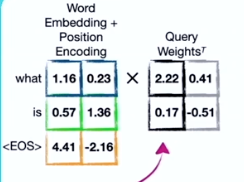

We then get 1 row per encoded token for the Query values:

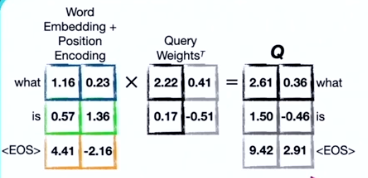

We then do this for the Key values and weights to get a new matrix K:

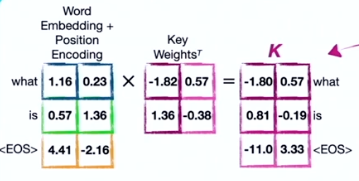

Lastly, we do this for Values and get a new matrix V:

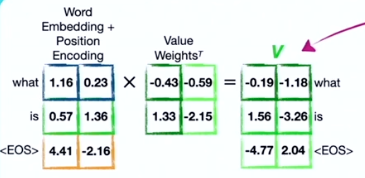

## Attention Mechanism
* Now we take the Q, K, V and use this to calculate Attention mechanism.

In [21]:
## attention
class Attention(nn.Module):
  # pass __init__() dim of model (num of word embedding values per token)
  ## d_model = 2 --> why? 2 word embedding models per token
  def __init__(self, d_model=2):

    # parent init
    super().__init__()
    self.d_model = d_model
    # Define row_dim and col_dim here
    self.row_dim = 1  # or 0, depending on your intended tensor dimensions
    self.col_dim = 0  # or 1, depending on your intended tensor dimensions


    ## nn.Linear() creates weight matrix
    ## W_q is untrained weights needed to calculate Query values
    self.W_q = nn.Linear(in_features=d_model, # num of rows
                         out_features=d_model, # num of cols
                         bias=False) # original transformers model no biased attention was set

    ## W_k untrained weights to calculate Key values
    self.W_k = nn.Linear(in_features=d_model, # num of rows
                         out_features=d_model, # num of cols
                         bias=False)
    ## W_v untrained weights to calculate V values
    self.W_v = nn.Linear(in_features=d_model, # num of rows
                         out_features=d_model, # num of cols
                         bias=False)


  # Forward Pass --> Now we calculate Masked Self Attention values for each token
  # we allow Q, K, V to be calculated from different token embeddings -- allows us to do encoder-decoder attention if we wanted
  ## however we are only going to build a decoder model
  def forward(self, encodings_for_q, encodings_for_k, encodings_for_v, mask=None):

    # now we calculate Query, Key, and Values for each token via Linear() function
    q = self.W_q(encodings_for_q)
    k = self.W_k(encodings_for_k)
    v = self.W_v(encodings_for_v)

    ## Here we build the Attention equation: Attention(Q,K,V) = SoftMax(((QK^T)/np.sqrt(dk))V)
    # 1. multiply q by transpose  -- calculates similarities between Queries and Keys
    ## similarities of new candidate word and all tokens before it
    sims = torch.matmul(q, k.transpose(dim0=self.row_dim, dim1=self.col_dim))

    # 2. Scale similarities by sqrt of num of values in each key
    scaled_sims = sims / torch.tensor(k.size(self.col_dim)**0.5)

    # 3. Add the mask --> if using 1 to scaled similarities
    ## note: if Encoder only transformer we DONT use a mask
    if mask is not None:
      scaled_sims = scaled_sims.masked_fill(mask=mask, value=-1e9)

    # 4. Run scaled similarities through softmax() function
    ## Note: Softmax scales all values between 0 and 1
    ## SoftMax() activation function --> scaled sims determines % influence each token has on other token
    ## These are the weights of the tokens relative to each other
    attention_percents = F.softmax(scaled_sims, dim=self.col_dim)

    # 5. torch.matmul() --> multiply attention percents (weights) by Values in V
    attention_scores = torch.matmul(attention_percents, v)

    return attention_scores




# Put ALL the pieces together
* Source: Statquest

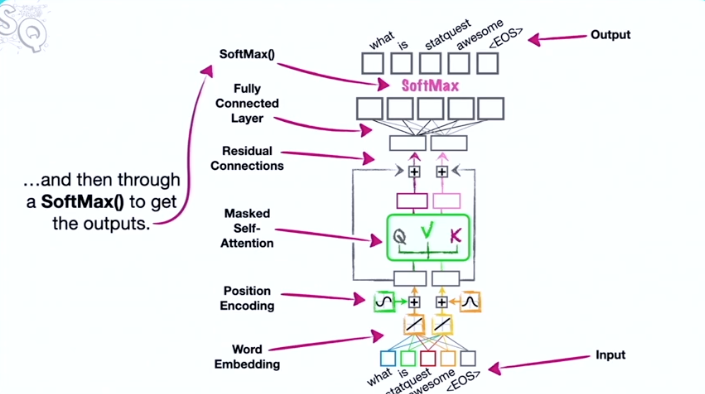

## Residual Connections
* Take values that come out of positional encodings --> bypasses attention layer.


# Creating Decoder Only Transformer Model
* This is unique because we are using `LightningModule`.
* Allows us to take advantage of everything Lightning offers without overhead of inherting multiple times, docs: https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

In [31]:
## decoder ONLY class
class DecoderOnlyTransformer(L.LightningModule):

  def __init__(self,
               num_tokens=4, #num tokens in vocab
               d_model=2, # num of values we want to represent each token
               max_len=3): #max len of input + output

    # parent init method -- initializes attributes of parent class
    super().__init__()


    # create embedding object for word embedding (we)
    self.we = nn.Embedding(num_embeddings=num_tokens, #num tokens in vocab
                           embedding_dim=d_model) #num values each token to represent

    # create position encoding
    self.pe = PositionEncoding(d_model=d_model,
                               max_len=max_len)

    # self attention
    self.self_attention = Attention(d_model=d_model)

    # fully connected linear layer - "fc" -- connect input to output features
    self.fc_layer = nn.Linear(in_features=d_model,
                              out_features=num_tokens)

    # loss function --> many outputs = CrossEntropyLoss
    ## applies SoftMax() function for us --> scales logits to between 0 and 1
    self.loss = nn.CrossEntropyLoss()



  # forward method -- input is array of token_id numbers used as inputs to transformer
  def forward(self, token_ids):

    # 1. convert tokens --> word embedding values
    word_embeddings = self.we(token_ids)
    # 2. embeddings --> position encodings
    position_encoded = self.pe(word_embeddings)

    # 3. create mask --> prevents early tokens from seeing late tokens
    ## torch.tril --> returns lower triangular part of matrix - everything else to 0s
    mask = torch.tril(torch.ones((token_ids.size(dim=0), token_ids.size(dim=0))))
    mask = mask == 0 #converts 0s to true, 1s to false

    # move mask to same device as model
    mask = mask.to(self.device)


    # 4. Calculate attention --> `position_encoded` is for Queries, Keys, Values
    ## mask is to always predict next token
    self_attention_values = self.self_attention(position_encoded,
                                                position_encoded,
                                                position_encoded,
                                                mask=mask)

    # 5. Residual connections
    residual_connection_values = position_encoded + self_attention_values

    # 6. Fully connected output layer -- connect input to output
    fc_layer_output = self.fc_layer(residual_connection_values)

    return fc_layer_output

  ## training code

  #1. optimizer + loss function
  def configure_optimizers(self):
    return Adam(self.parameters(), lr=0.1)

  # 2. actual training
  def training_step(self, batch, batch_idx):
  # split data into inputs and labels
    input_tokens, labels = batch

  # forward pass
    output = self.forward(input_tokens[0])

  #loss function calculates Softmax for us
    loss = self.loss(output, labels[0])

    return loss




# Train the Decoder model
* This code trains the model.
* Using PyTorch Lightning this is easier.

In [72]:
## create a model
## seed everything lightning
#seed_everything(42) ## if want same outputs

## create a model
model = DecoderOnlyTransformer(num_tokens=len(token_to_id),
                               d_model=2,
                               max_len=6) ## can have up to 6 tokens -- wicked small model!


# create input prompt -- predicting after EOS token
model_input = torch.tensor([token_to_id["what"],
                           token_to_id["is"],
                           token_to_id["generative AI"],
                           token_to_id["<EOS>"]])


# create input prompt -- predicting after EOS token
#model_input = torch.tensor([token_to_id["generative AI"],
                            #token_to_id["is"],
                            #token_to_id["what"],
                            #token_to_id["<EOS>"]])


# num of input tokens
input_length = model_input.size(dim=0)

# pass to model --> generate tokens for each input
predictions = model(model_input)
## argmax --> token with largest value!
# we don't have to always take the largest probability token
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
## print output token
predicted_ids = predicted_id


# loop & generate output tokens
max_length = 6
for i in range(input_length, max_length):
    if (predicted_id == token_to_id["<EOS>"]):
      break

    model_input = torch.cat((model_input, predicted_id))

    predictions = model(model_input)
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))

# print generated tokens after converting
print("Predicted Tokens:\n")
for id in predicted_ids:
  print("\t", id_to_token[id.item()])


Predicted Tokens:

	 awesome
	 awesome
	 awesome


In [71]:
## Lightning trainer model
trainer = L.Trainer(max_epochs=30)
trainer.fit(model, train_dataloaders=dataloader)


INFO:lightning_fabric.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | we             | Embedding        | 10     | train
1 | pe             | PositionEncoding | 0      | train
2 | self_attention | Attention        | 12     | train
3 | fc_layer       | Linear           | 15     | train
4 | loss           | CrossEntropyLoss | 0      | train
------------------------------------------------------------
37        Trainable params
0         Non-trainable params
37        Total params
0.000     Total estimated model params size (MB)
8         Modules in train mode
0     

Training: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


# Summary
* We were able to build a decoder generative AI model from scratch.
* Obviously the input vocabulary was very small but it helped us to see the various layers of the model.
* If you wanted the SAME output with every run of the model you can use the `seed_everything` in PyTorch Lightning and set it to 42.